In [11]:
import pandas as pd
import geopandas as gp

%pylab inline
import matplotlib.pyplot as plt

import os
import pickle

from scipy.cluster.vq import kmeans2
import Pycluster


Populating the interactive namespace from numpy and matplotlib


In [12]:
def nColors(k=2, cmap='spectral'):

    from pylab import get_cmap
    
    if type(cmap) == str:
        cm = get_cmap(cmap)
        colors = [cm(1.*i/(k-1)) for i in range(k)]
    elif cmap==None:
        colors = ['k']
    else:
        colors = cmap
        
    return colors
    

In [13]:
def clusterAndPlot(df,k, height=10, engine='PyCluster', cmap='spectral'):
    '''calculate and plot kmean clustering'''
    fig, axes = plt.subplots(k+1, figsize=(18,height), sharex='all', sharey='all')
    
    if engine == 'scipy':
        centroids, label = kmeans2(df, k, iter=100, thresh=1e-05)
    else:
        labels, error, nfound = Pycluster.kcluster(df, k)
    df['label'] = labels
    
    
    colors = nColors(k=k, cmap=cmap)
        
    #one by one
    for l, g in df.groupby('label'):
        g.T.plot(ax=axes[l], legend=0, c=colors[l],alpha=.2)
        axes[l].set_title('cluster %d, %d zipcodes'% (l, len(g)))
        
        pd.Series(g.mean(0)).plot(ax=axes[-1], label='cluster %d'% (l ), c=colors[l])
        
    #     plt.legend()
    return df

In [14]:
def normaliseTimeseries(df, transpose=True):
    '''transpose and normilize timeseries by themself
       removing the median and dividing by sdt'''
    
    if transpose:
        df = df.T
    
    return (df - df.mean(0))/df.std(0)
    

In [15]:
def averageWeek(df, ax, tcol='ts', ccol='id', label=None, treshold=0, normalize=True, verbose=False, **kwargs):
    '''calculate average week on ts'''
    
    s = df[[tcol, ccol]].rename(columns={tcol:'ts',ccol:'id'}) # rename to convention
    
    s = df[['id', 'ts']].set_index('ts').resample('15Min', how='count').reset_index()
    s['id'] = s['id'].astype(float)


    s['ts'] = s.ts.apply(lambda x: datetime.datetime(year=2015,month=1, 
                                                              day=(x.weekday()+1), 
                                                              hour=x.hour, 
                                                              minute = x.minute))
    
    s = s.groupby(['ts']).agg('mean')
    
    
    if not label:
        label = ccol
    
    if s.id.sum() >= treshold:
        
        if normalize:
            sNorm = 1.0*s/s.sum()
        else:
            sNorm = s
        
        sNorm.rename(columns={'id':label}, inplace=1) 
        sNorm.plot(ax=ax, legend=False, **kwargs);

        return sNorm.rename(columns={'id':label})
        
    else:
        if verbose:
            print name, 'didnt pass treshhold:', s['id'].sum()

        pass
    
    

In [16]:
def bulkWeeks(df, attr, title='', av=False, th=0, legend=False, **kwargs):
    fig, ax = plt.subplots(figsize=(18,6))

    weeks = []


    for name, g in df.groupby(attr):
        zs = averageWeek(g, ax=ax, label=name, alpha=.5, treshold=th, **kwargs)
        weeks.append(zs)
    
    data = pd.concat(weeks, axis=1)
    if av:
        d = data.mean(axis=1)
        (1.0*d/d.sum()).plot(ax=ax, lw=1.4, color='k', label='Average')


    ax.set_title('%s, treshold=%d' % (title,th), fontsize=15);
    
    if legend:
        ax.legend()

    labels = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    dates = [datetime.datetime(year=2015, month=1, day=i, hour=0, minute=0) for i in range(1,8)]

    ax.set_xticklabels([],minor=False) # the default
    ax.set_xticklabels(labels,minor=True)

    for d in dates:
        ax.axvline(x=d, ymin=0, ymax=1, alpha=.5, linewidth=4)

    return data
    
    

## Getting Data

In [20]:
# zipcode maps
zipPath = os.getenv('PWD') + '/data/misk/nyc-zip-code-tabulation-areas-polygons.geojson'
zips = gp.read_file(zipPath)[['geometry', 'postalCode']]
print zips.crs

{'init': u'epsg:4326'}


In [22]:
# dataset to cluster
datum = pd.read_pickle(os.getenv('PWD') + '/code/zipJoined.pkl')

In [23]:
d = datum.drop(['tweet', 'lon', 'lat', 'rtwts', 'fvrts','geometry', 'application', 'source', 'timestamp','index_right','user_id'], axis=1)

In [24]:
d.head(2)

,id,ts,postalCode
0,550441283261857792,2015-01-01 00:00:03,11420
1,550441288076914688,2015-01-01 00:00:04,10038


In [25]:
zcodes.max(0).sort_values(ascending=0).head(3)

NameError: name 'zcodes' is not defined

(0, 0.15)

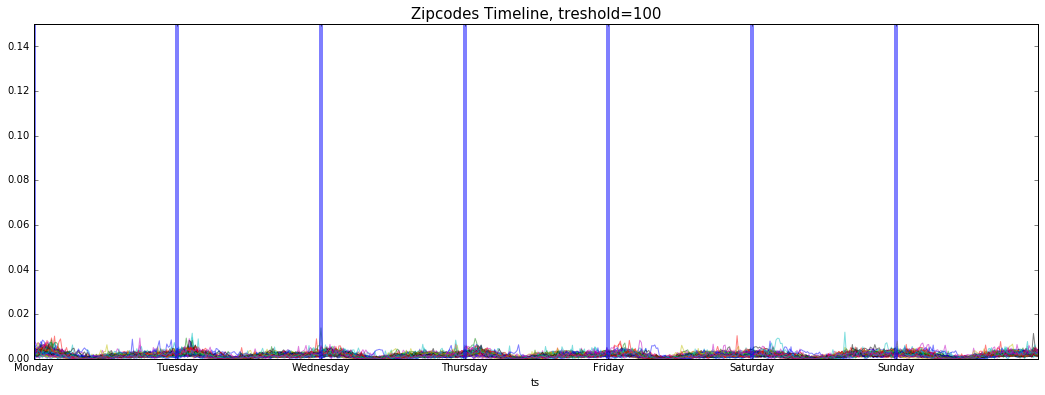

In [26]:
zcodes = bulkWeeks(d, attr='postalCode', title='Zipcodes Timeline', av=False, th=100, legend=False)
plt.ylim(0, 0.15)

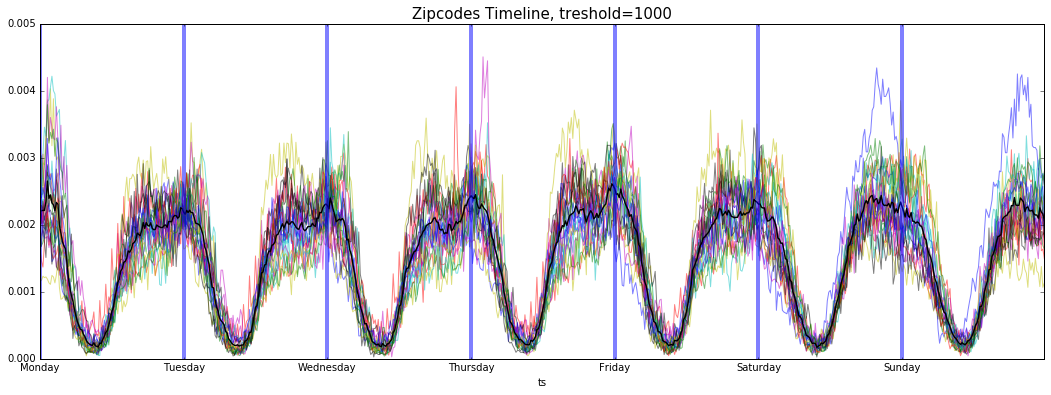

In [27]:
zcodesN = bulkWeeks(d, attr='postalCode', title='Zipcodes Timeline', av=True, th=1000, legend=False, normalize=True)

In [28]:
len(set(zcodesN.columns.tolist()))

23

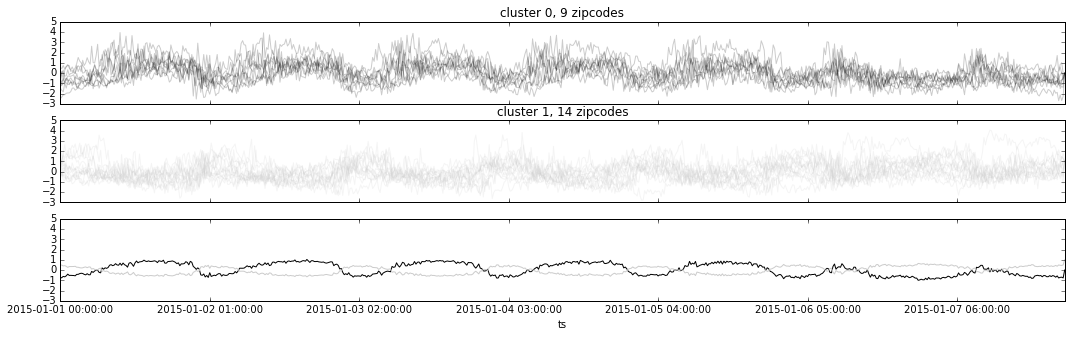

In [29]:
dfLabels = clusterAndPlot(normaliseTimeseries(zcodesN) , 2, height=5)

In [30]:
labels = dfLabels.reset_index()[['index','label']].rename(columns={'index':'postalCode'})
labelZip = zips.merge(labels, how='left', on='postalCode')

/Users/casy/anaconda/lib/python2.7/site-packages/geopandas-0.1.0.dev1451292-py2.7.egg/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)


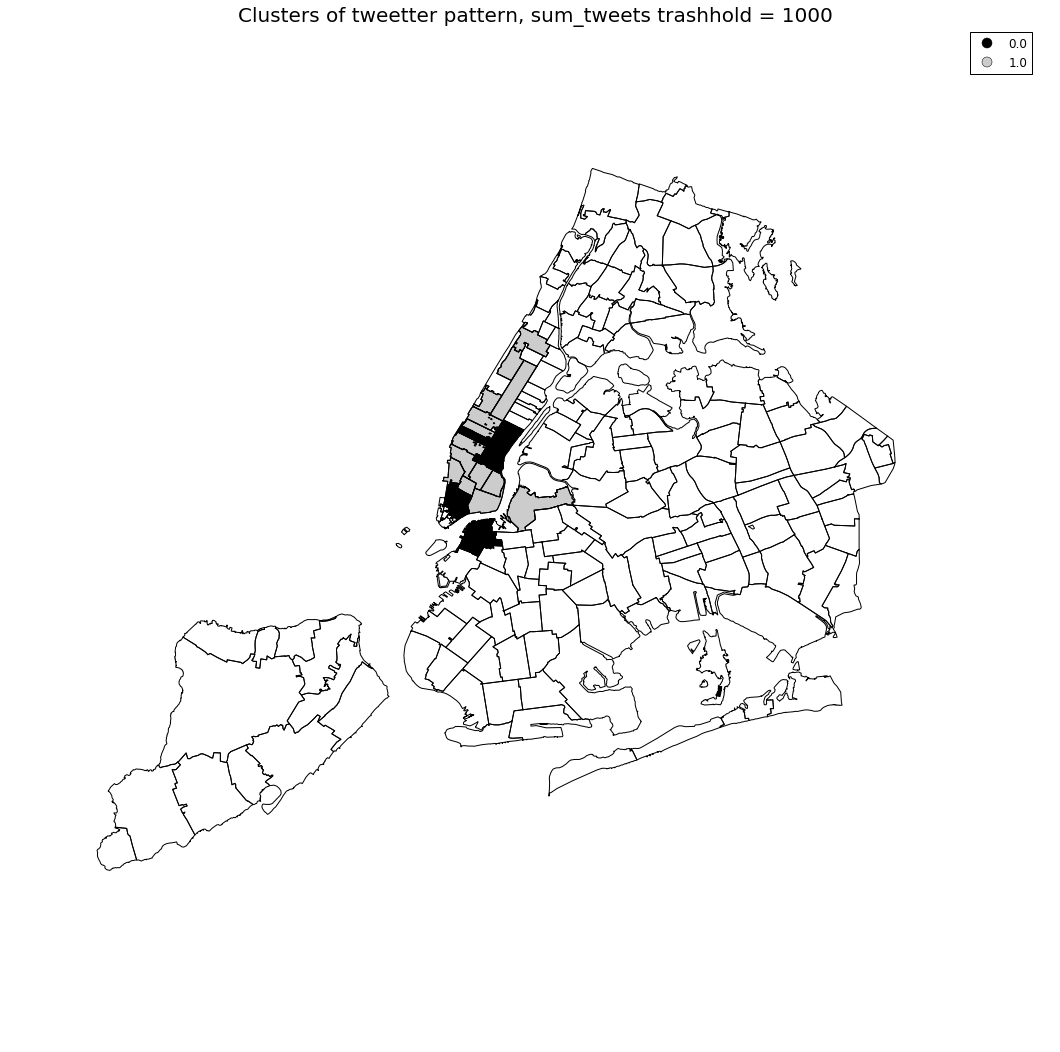

In [31]:
fig, ax = plt.subplots(figsize=(18,18))

labelZip.plot(alpha=0, ax=ax) # empty back
labelZip[pd.notnull(labelZip.label)].plot(column='label', categorical=1,
           colormap='spectral', ax=ax,
           alpha=1, legend=True)

plt.title('Clusters of tweetter pattern, sum_tweets trashhold = 1000', fontsize=20)
plt.axis('off');

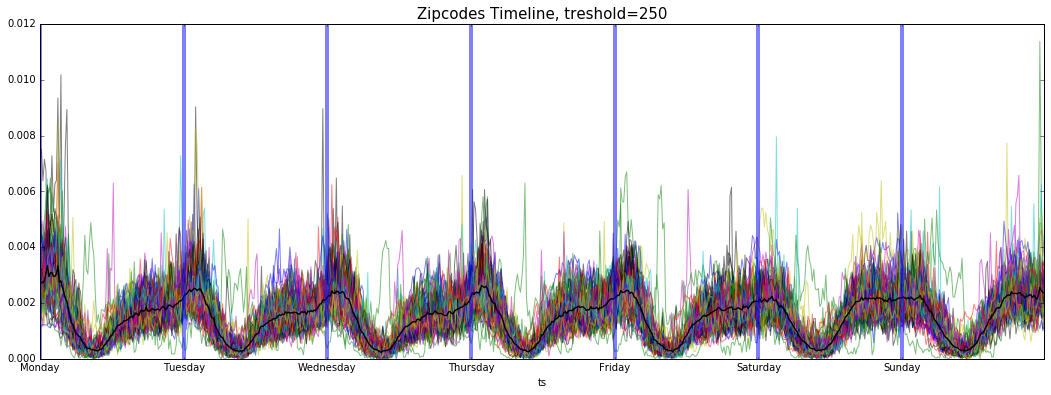

In [32]:
zcodesN250 = bulkWeeks(d, attr='postalCode', title='Zipcodes Timeline', av=True, th=250, legend=False, normalize=True)

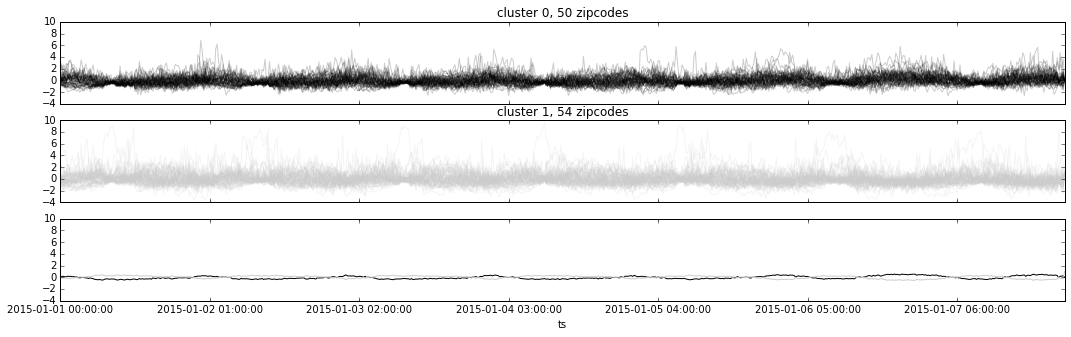

In [33]:
dfLabels250 = clusterAndPlot(normaliseTimeseries(zcodesN250) , 2, height=5)

In [34]:
labels250 = dfLabels250.reset_index()[['index','label']].rename(columns={'index':'postalCode'})
labelZip250 = zips.merge(labels250, how='left', on='postalCode')

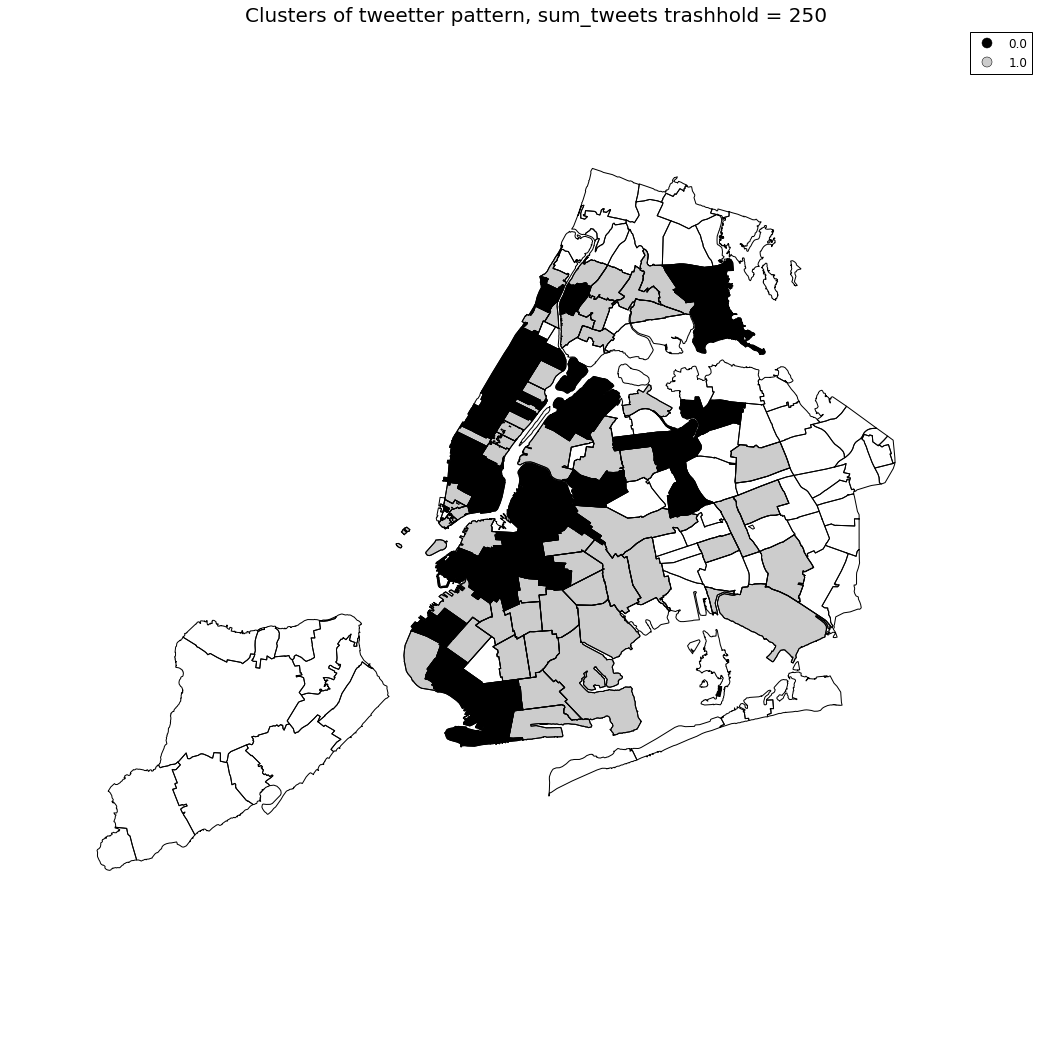

In [35]:
fig, ax = plt.subplots(figsize=(18,18))

labelZip250.plot(alpha=0, ax=ax) # empty back
labelZip250[pd.notnull(labelZip250.label)].plot(column='label', categorical=1,
           colormap='spectral', ax=ax,
           alpha=1, legend=True)

plt.title('Clusters of tweetter pattern, sum_tweets trashhold = 250', fontsize=20)
plt.axis('off');

## SILHOUETTE

In [36]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


import matplotlib.cm as cm
import numpy as np


In [39]:
def Silhuette(X, range_n_clusters=(2,3,4,5,6)):


    for n_clusters in range_n_clusters:

        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])

        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhoutte score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors)

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1],
                    marker='o', c="white", alpha=1, s=200)

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()

('For n_clusters =', 2, 'The average silhouette_score is :', 0.13015976426022638)


TypeError: unhashable type

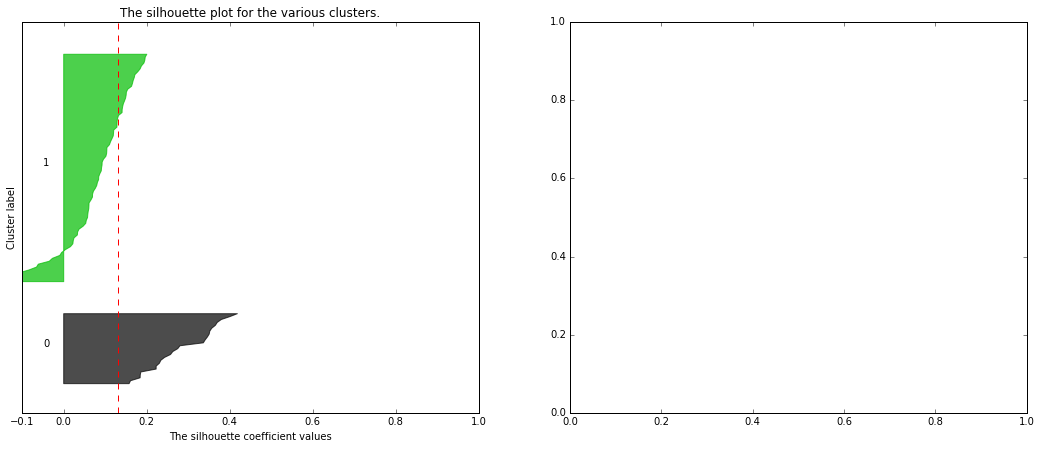

In [40]:
Silhuette(normaliseTimeseries(zcodesN250))

## CLUSTERING 2

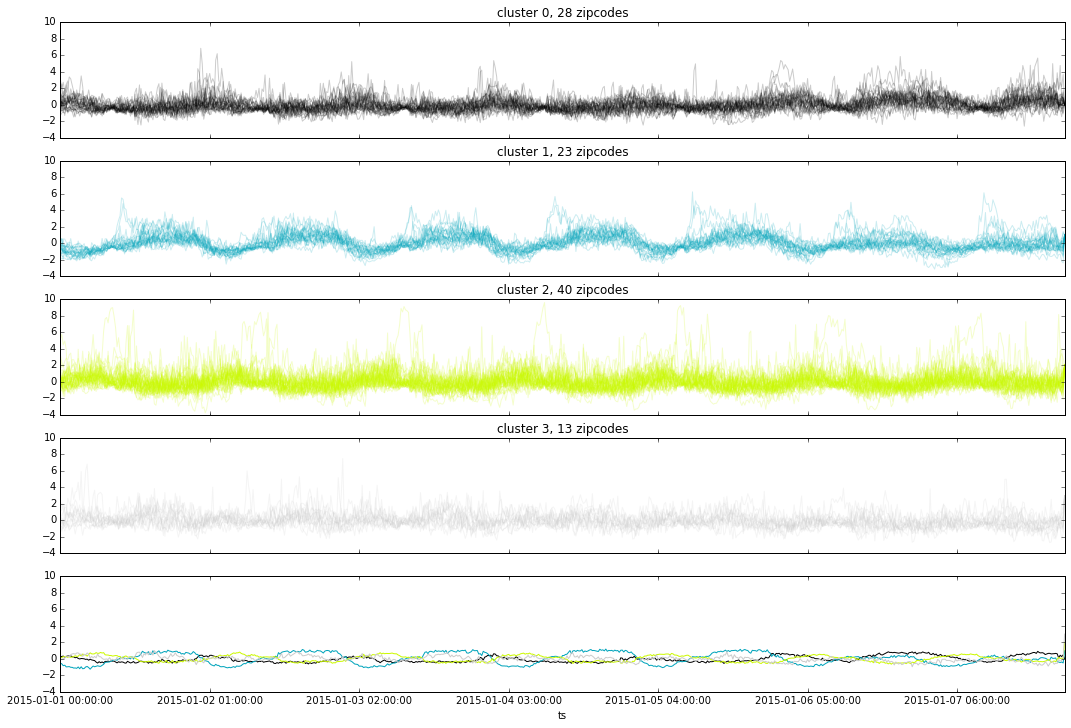

In [141]:
dfLabels250_4 = clusterAndPlot(normaliseTimeseries(zcodesN250) , 4, height=12)

In [142]:
def plotLabels(dfLabels, zips, title='Clusters of tweetter pattern', cmap='spectral'):
    labelsD = dfLabels.reset_index()[['index','label']].rename(columns={'index':'postalCode'})
    labelZip = zips.merge(labelsD, how='left', on='postalCode')
    
    fig, ax = plt.subplots(figsize=(18,18))

    labelZip.plot(alpha=0, ax=ax) # empty back
    labelZip[pd.notnull(labelZip.label)].plot(column='label', categorical=1,
               colormap=cmap, ax=ax,
               alpha=1, legend=True)

    plt.title('Clusters of tweetter pattern, sum_tweets trashhold = 250', fontsize=20)
    plt.axis('off');

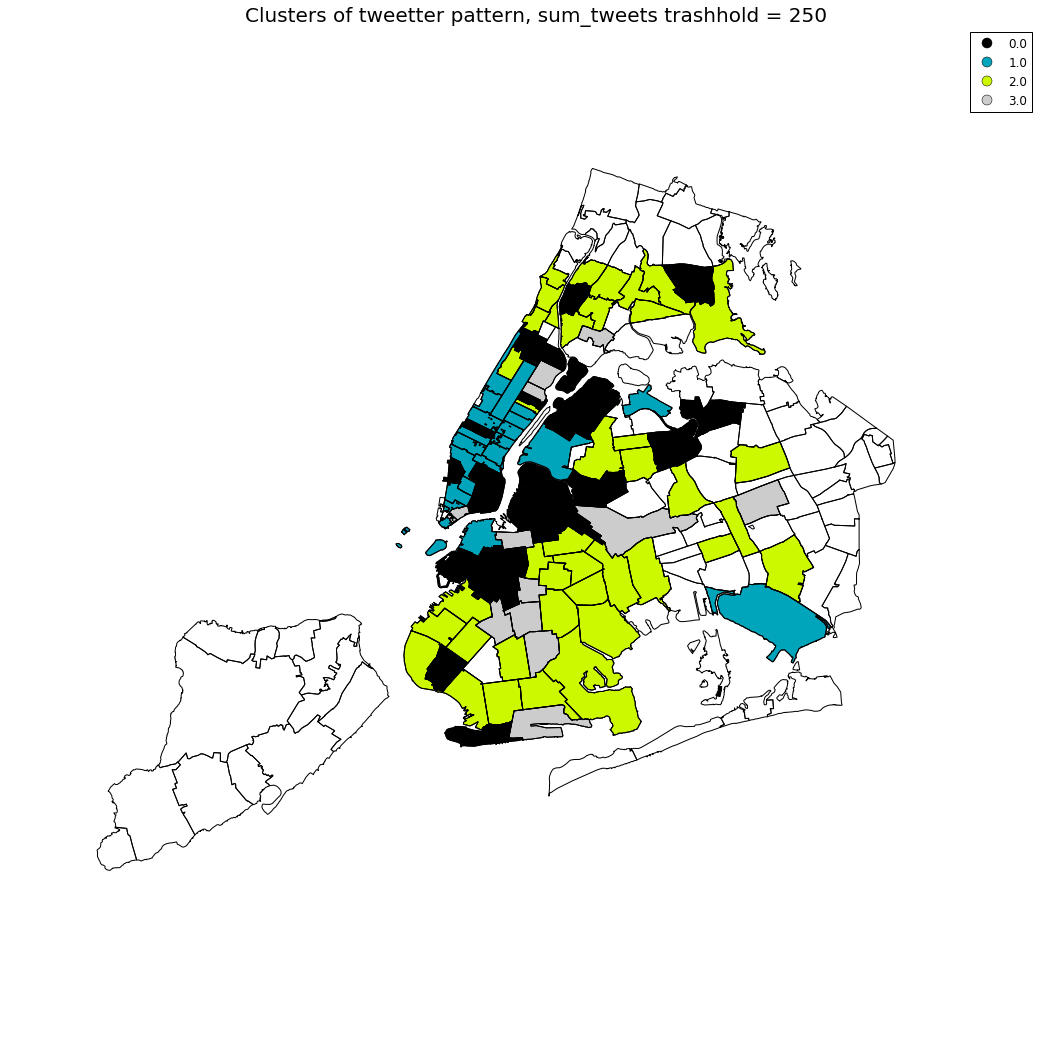

In [143]:
plotLabels(dfLabels250_4, zips, title='Clusters of tweetter pattern, 4, trashold=250', cmap='spectral')

#### Summary timeline for labels

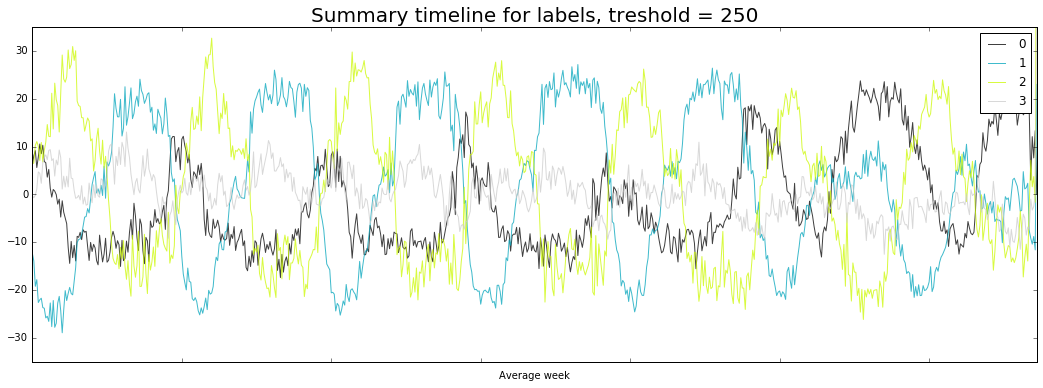

In [178]:
fig, ax = plt.subplots(figsize=(18,6))

N = len(dfLabels250_4.label.unique())

colors = nColors(N, cmap='spectral')
for name, g in dfLabels250_4.groupby('label'):
    g.sum(0).plot(ax=ax, alpha=.75, c=colors[name], label=name)

labels = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
dates = [datetime.datetime(year=2015, month=1, day=i, hour=0, minute=0) for i in range(1,8)]

ax.set_xticklabels([],minor=False) # the default
ax.set_xticklabels(labels,minor=True)

ax.legend()
plt.ylim(-35,35);
plt.xlabel('Average week');
plt.title('Summary timeline for labels, treshold = 250', fontsize=20);